In [48]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import functools as func
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.preprocessing import StandardScaler

In [49]:
# Importing and preparing the datasets
flow_data = pd.read_csv('flow_2017.csv', parse_dates = ['timestamp'], index_col = 'timestamp')
# change to absolute value of flows - to represent activity
flow_data['flow'] = abs(flow_data['flow'])
# Change to by the day 
flow_data = flow_data.resample('D').sum()

humidity_data = pd.read_csv('humidity_2017.csv', parse_dates = ['timestamp'], index_col = 'timestamp')
humidity_data = humidity_data.resample('D').mean()
temp_data = pd.read_csv('temperature_2017.csv', parse_dates = ['timestamp'], index_col = 'timestamp')
temp_data = temp_data.resample('D').mean()
weight_data = pd.read_csv('weight_2017.csv', parse_dates = ['timestamp'], index_col = 'timestamp')
weight_data = weight_data.resample('D').mean()

# Merge the 4 data columns on time series index. 
ds = [flow_data, humidity_data, temp_data, weight_data]
dataset = func.reduce(lambda left,right: pd.merge(left, right, left_index = True, right_index = True),ds)


In [50]:
# Choosing X and y 
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, 3].values

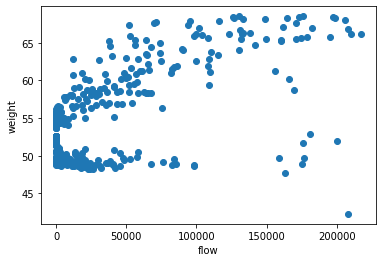

In [54]:
# Compare individual independent variable to dependent variable to assess relationships between variables
%matplotlib inline
plt.scatter(dataset['flow'], dataset['weight'])
plt.ylabel('weight')
plt.xlabel('flow')
plt.show()


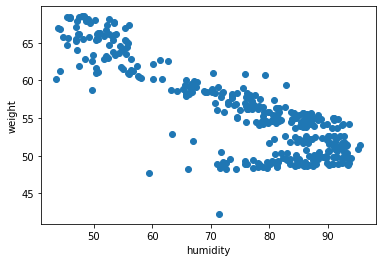

In [55]:
plt.scatter(dataset['humidity'], dataset['weight'])
plt.ylabel('weight')
plt.xlabel('humidity')
plt.show()

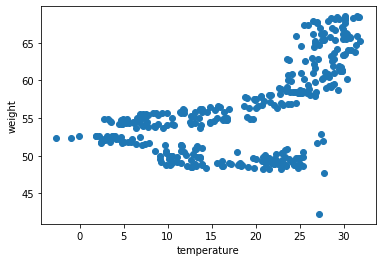

In [56]:
plt.scatter(dataset['temperature'], dataset['weight'])
plt.ylabel('weight')
plt.xlabel('temperature')
plt.show()

Relationships between beehive weight and flow, beehive weight and humidity and beehive weight temperature do not appear linear. It is predicted that a regression equation without polymial variables or non linear parameters will poorly model the effects of flow, humidity and temperature on beehive weight. 

In [57]:
# Check independent variables for multicollinearity with variance inflation factor
X = pd.DataFrame(data = X)
X.columns = ['flow', 'humidity', 'temp']
vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


  variables       VIF
0      flow  3.756776
1  humidity  4.244326
2      temp  8.976867


In [58]:
# Standardize the coefficients as they have different ranges and to attempt to fix multicollinearity
sc_X = StandardScaler()
X = sc_X.fit_transform(X)
X = np.append(arr = np.ones((365,1)).astype(int), values = X, axis = 1)
X = pd.DataFrame(data = X)
X.columns = ['y_int','flow', 'humidity', 'temp']


In [59]:
# Recheck variance inflation factors
vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)

  variables       VIF
0     y_int  1.000000
1      flow  2.655202
2  humidity  2.899353
3      temp  2.874906


In [60]:
# Selecting optimal model using backward elimination 
X_opt = X.copy()
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     319.1
Date:                Mon, 06 Jan 2020   Prob (F-statistic):          3.73e-101
Time:                        13:17:36   Log-Likelihood:                -928.94
No. Observations:                 365   AIC:                             1866.
Df Residuals:                     361   BIC:                             1881.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
y_int         55.9427      0.162    344.699      0.000      55.624      56.262
flow          -0.2441      0.264     -0.923      0.357      -0.764       0.276
humidity      -5.7327      0.276    -20.745      0.000      -6.276      -5.189
temp          -0.7318      0.275     -2.659      0.008      -1.273      -0.191
==============================================================================
Omnibus:                       78.324   Durbin-Watson:                   0.313
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.418
Skew:                          -1.172   Prob(JB):                     1.61e-32
Kurtosis:                       5.032   Cond. No.                         3.27
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
# Selecting optimal model
X_opt = X_opt[['y_int', 'humidity', 'temp']]
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.726
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     478.5
Date:                Mon, 06 Jan 2020   Prob (F-statistic):          2.31e-102
Time:                        13:17:37   Log-Likelihood:                -929.37
No. Observations:                 365   AIC:                             1865.
Df Residuals:                     362   BIC:                             1876.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
y_int         55.9427      0.162    344.769      0.000      55.624      56.262
humidity      -5.6288      0.252    -22.307      0.000      -6.125      -5.133
temp          -0.8330      0.252     -3.301      0.001      -1.329      -0.337
==============================================================================
Omnibus:                       83.318   Durbin-Watson:                   0.309
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.966
Skew:                          -1.213   Prob(JB):                     1.51e-36
Kurtosis:                       5.228   Cond. No.                         2.75
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [62]:
# Split the dataset
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X_opt,y, test_size = 0.2, random_state = 0)

# Fit the linear regression to the training set
regressor_train = sm.OLS(endog = y_train, exog = X_train).fit()

# Use the X_test data to produce a set of y prediction and then determine the residuals
Y_pred = regressor_OLS.predict(X_test)
residuals = Y_pred - y_test

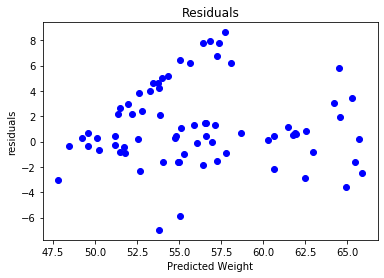

In [63]:
# Plot the residuals 
plt.scatter(Y_pred, residuals, color = 'blue')
plt.title('Residuals')
plt.xlabel('Predicted Weight')
plt.ylabel('residuals')
plt.show()

The residuals are heteroskedastic implying that there are patterns in the data not captured by regression model. A polynomial regression or a regression model with non linear parameters might be able to yield homoskedastic errors if the increasing residuals are due to using the incorrect regression equation for the included variables.